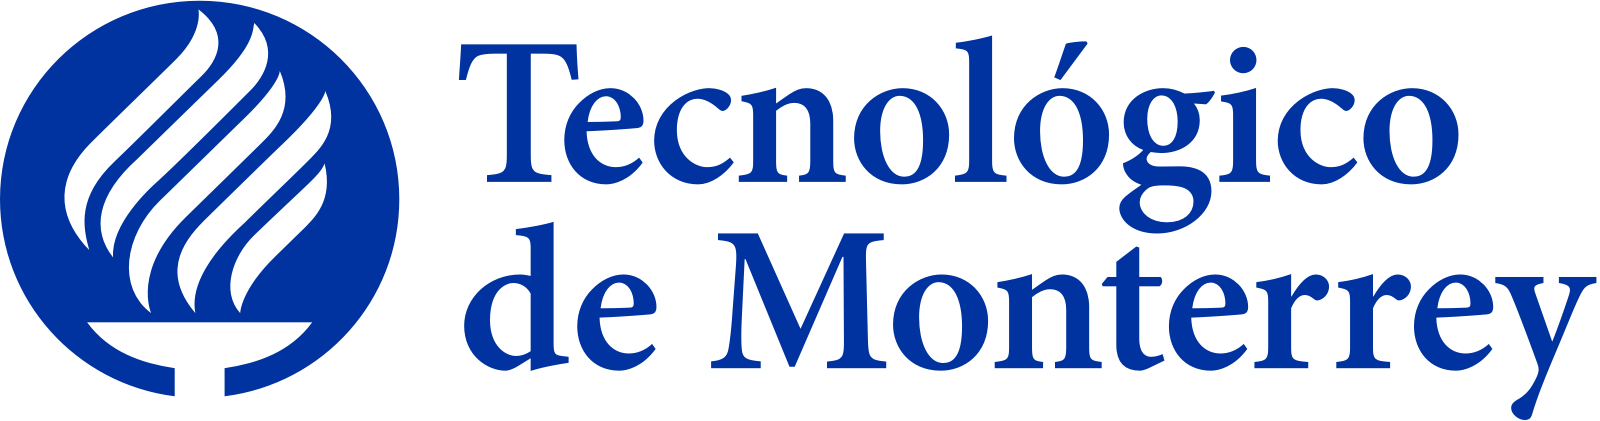

---
# Instituto Tecnológico y de Estudios Superiores de Monterrey


## **Capstone Project (Team #49)**


### **Stage 3.** Baseline


#### *Author:* Julia Gabriela Pinedo -- A01795315

#### *Professor:* Dr. Grettel Barceló Alonso
#### *Project Advisor:* Dr. Guillermo Mota Medina

---

## Table of Contents
1. [Introduction](#intro)
2. [Algorithm](#algo)
3. [Features](#fe)
4. [Under/Overfitting](#under)
5. [Metrics](#met)
6. [Performance](#per)
7. [References](#references)

---

# Introduction <a class="anchor" id="intro" ></a>

Following the improvements established in **Stage 1**, the modeling environment in Gazebo Harmonic and the ROS2 Jazzy bridge were fully stabilized (**Figure 1**). The simulation now delivers consistent, high-frequency telemetry streams for both the robot and the box, enabling the generation of structure, learning-ready data suitable for Reinforcement Learning.

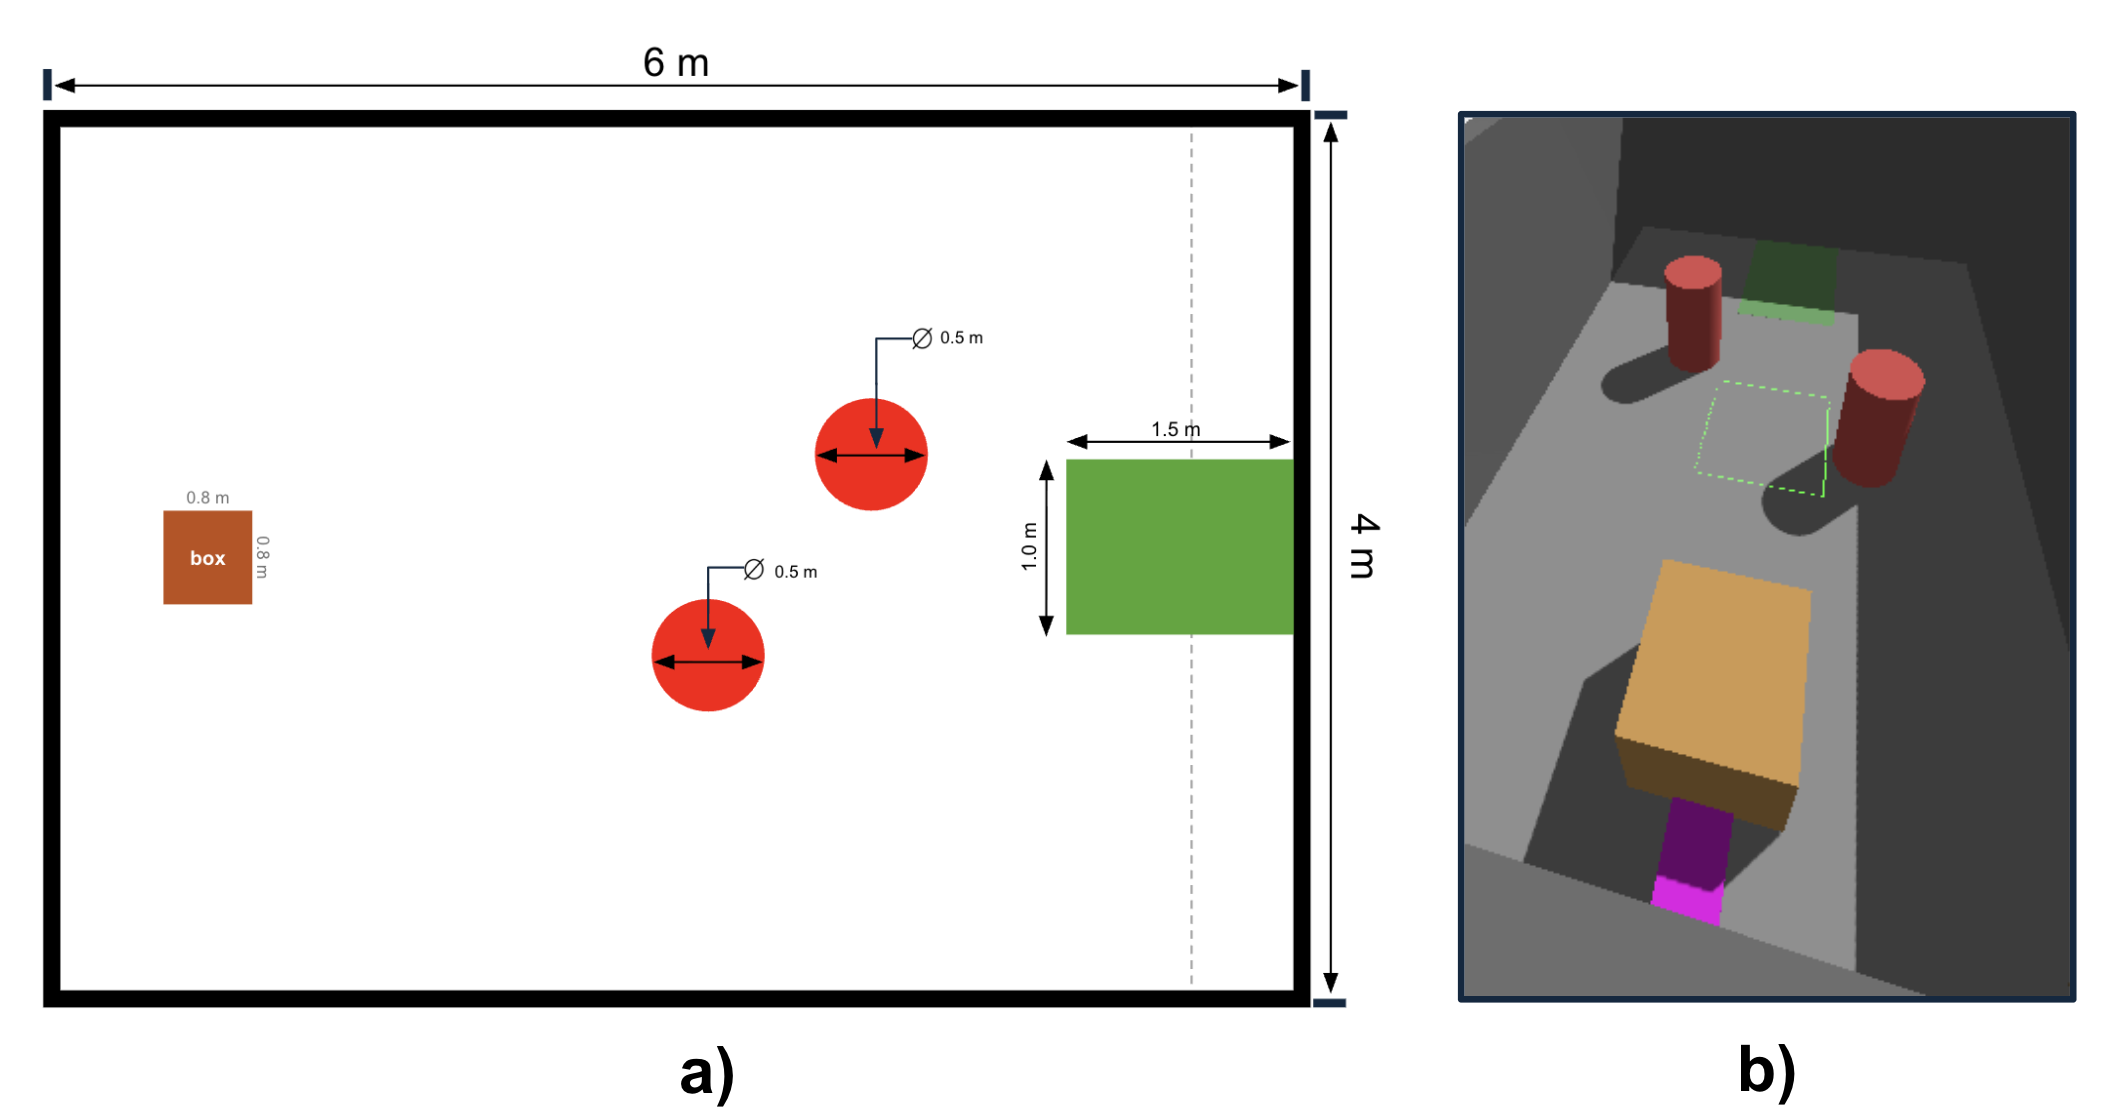
**Figure 1.** Simulation environment. a) Diagram of the arena, b) Arena modeled and simulated in Gazebo.

The goal-driven spawn geometry, curriculum-based obstacle setup, and telemetry robustness implemented earlier ensure that every episode produces coherent, noise-reduced sensor readings. These modifications effectively eliminated missing or null poses, allowing the pipeline to focus on policy optimization rather than data integrity. 

During **Stage 2**, the setup transitioned into a Reinforcement Learning system, in which the agent continually generates its own experience through the sequence of transitions: $(s_{t},a_{t},r_{t},s_{t+1})$ as it learns to push the box toward the goal. 

Since the data is generated *online*, the preparation phase does not consist of classical cleaning or imputation. Instead, the focus lies in real-time feature scaling and normalization within the agent's loop to maintain numerical stability during the Q-value updates. These transformations are executed in memory at every timestep before computing the next action.

---

## MinMax Scaler:

---
```python
class RunningMinMax:
    """
    Online MinMaxScaler for known physical ranges.
    If (lo, hi) are provided, uses them as fixed bounds; otherwise adapts online.
    """
    def __init__(self, lo=None, hi=None):
        self.fixed = (lo is not None) and (hi is not None)
        self.lo = np.array(lo, dtype=float) if lo is not None else None
        self.hi = np.array(hi, dtype=float) if hi is not None else None

    def partial_fit(self, x):
        """Update running min/max statistics"""
        x = np.asarray(x, dtype=float)
        if self.fixed:
            return  # Don't update if using fixed bounds
        if self.lo is None:
            self.lo = x.copy()
            self.hi = x.copy()
        else:
            self.lo = np.minimum(self.lo, x)
            self.hi = np.maximum(self.hi, x)

    def transform(self, x):
        """Scale to [0, 1] range"""
        x = np.asarray(x, dtype=float)
        lo, hi = self.lo, self.hi
        # Avoid division by zero
        den = np.where((hi - lo) == 0.0, 1.0, (hi - lo))
        return np.clip((x - lo) / den, 0.0, 1.0)
```
---

## Standard Scaler:

---
```python
class RunningStandard:
    """
    Online StandardScaler using Welford's algorithm for numerical stability.
    Computes running mean and variance without storing all samples.
    """
    def __init__(self, dim):
        self.n = 0
        self.mean = np.zeros(dim, dtype=float)
        self.M2 = np.zeros(dim, dtype=float)  # Sum of squared differences

    def partial_fit(self, x):
        """Update running mean and variance"""
        x = np.asarray(x, dtype=float)
        if self.n == 0:
            self.mean = np.zeros_like(x)
            self.M2 = np.zeros_like(x)
        self.n += 1
        delta = x - self.mean
        self.mean += delta / self.n
        delta2 = x - self.mean
        self.M2 += delta * delta2

    def transform(self, x):
        """Standardize to zero mean, unit variance"""
        x = np.asarray(x, dtype=float)
        if self.n <= 1:
            return x  # Not enough samples yet
        var = self.M2 / (self.n - 1)
        std = np.where(var == 0.0, 1.0, np.sqrt(var))
        return (x - self.mean) / std
```
---

This approach guarantees that, regardless of how the robot moves or how the simulation evolves, all input dimensions remain numerically comparable, preventing any single sensor from dominating the update process. As a result, the RL agent operates over a well-balanced and dynamically normalized feature space, ensuring stable convergence and reproducible learning behavior.

# Algorithm <a class="anchor" id="algo" ></a>

Since our agent interacts *online* with a fully instrumented, simulated control task, the observations are **structured, numeric, and sequential** (poses, velocities, IMU, distances), and do not make part of an offline dataset. This configuration enables the agent to continuously generate its own experiences with the Gazebo + ROS2 environment, capturing the dynamic nature of decision-making under uncertainty.

We already followed this standard procedure in **Stage 2**, where the agent's state and action representations were defined and stabilized:

- **State/action size:** We discretized ~13 real-time features into a manageable finite state space (2.1M bins after coarse 3-bin quantization) and a small discrete action set (4 actions). This configuration makes the problem computationally tractable while preserving the essential dynamics of the task.
- **Relevant features and online preprocessing:** The pipeline (*as discussed in the Introduction*) applies **Min-Max** to spatial variables, **Standardization** to dynamics/IMU, and **encodes** binary flags (contact, in-goal). This normalization ensures all dimensions remain numerically comparable, promoting stable convergence.
- **Interpretability:** Each $Q(s,a)$ entry maps directly to a physical situation, allowing a straightforward inspection of reward shaping, exploration effects, and atypical agent behaviors.

In contrast to conventional machine learning algorithms, where the models learn from a fixed offline dataset of labeled examples, Reinforcement Learning involves an agent that learns online *through direct interaction* with its environment. As previously discussed, **learning is driven by sequential decision-making under uncertainty**, where each action influences future states and rewards. Since the agent generates its own experience through transitions $(s_{t},a_{t},r_{t},s_{t+1})$, it aligns perfectly with the **Markov Decision Process (MDP)** formulation and a **value-learning framework** [13][14].

The environment in Gazebo exhibits partially deterministic dynamics governed by rigid-body physics and sensor noise, making the transition probabilities $P(s'|s,a)$ stable yet not perfectly predictable. Moreover, since the control space is discrete and the number of possible transitions is finite, the **tabular** representation ensures convergence to the optimal policy without the need for function approximation, which would otherwise introduce bias or instability.

For these reasons, **Tabular Q-Learning** was selected as the baseline algorithm. It directly estimates the optimal action-value function $Q*(s,a)$ using the **Bellman optimality update**, which iteratively refines expected returns for each state-action pair according to **Equation 1**:

$Q(s_t, a_t) \leftarrow Q(s_t, a_t) +
\alpha [ r_t + \gamma \max_{a'} Q(s_{t+1}, a') - Q(s_t, a_t) ]$ ... **(1)**

This off-policy formulation ensures convergence in finite MDPs under standard assumptions such as sufficient exploration and decaying step sizes. An additional advantage of the tabular approach lies in its transparency, which makes it easier to diagnose anomalies and verify that policy updates correspond to intuitive motion patterns, an insight often obscured in deep function approximators [14][15].

---
```python
class QAgent:
    """
    Tabular Q-learning with ε-greedy exploration.
    
    Q-learning update rule:
        Q(s,a) ← Q(s,a) + α[r + γ max_a' Q(s',a') - Q(s,a)]
    """
    def __init__(self, n_actions=4, alpha=0.1, gamma=0.95, eps=1.0, eps_min=0.05, eps_decay=0.99):
        self.nA = n_actions
        self.alpha = alpha          # Learning rate
        self.gamma = gamma          # Discount factor
        self.eps = eps              # Exploration rate
        self.eps_min = eps_min      # Minimum exploration
        self.eps_decay = eps_decay  # Decay rate per episode
        self.Q = {}                 # Q-table: {(state, action): value}

    def _q(self, s, a):
        """Get Q-value with default 0.0 for unseen state-action pairs"""
        return self.Q.get((s, a), 0.0)

    def act(self, s):
        """ε-greedy action selection"""
        if np.random.rand() < self.eps:
            return np.random.randint(self.nA)  # Explore
        else:
            qs = [self._q(s, a) for a in range(self.nA)]
            return int(np.argmax(qs))  # Exploit

    def update(self, s, a, r, s2, done):
        """Q-learning update"""
        if done:
            target = r  # No future reward
        else:
            best_next = max(self._q(s2, a2) for a2 in range(self.nA))
            target = r + self.gamma * best_next
        
        old_q = self._q(s, a)
        self.Q[(s, a)] = old_q + self.alpha * (target - old_q)

    def decay(self):
        """Decay exploration rate"""
        self.eps = max(self.eps_min, self.eps * self.eps_decay)
    
    def save(self, path):
        """Save Q-table and hyperparameters to JSON"""
        os.makedirs(os.path.dirname(path) or '.', exist_ok=True)
        with open(path, 'w') as f:
            # Serialize state tuples as strings
            q_serializable = {f"{s}||{a}": float(v) for (s, a), v in self.Q.items()}
            json.dump({
                'Q': q_serializable,
                'params': {
                    'alpha': float(self.alpha),
                    'gamma': float(self.gamma),
                    'eps': float(self.eps),
                    'nA': int(self.nA)
                }
            }, f, indent=2)
    
    def load(self, path):
        """Load Q-table and hyperparameters from JSON"""
        with open(path, 'r') as f:
            data = json.load(f)
            self.Q = {}
            for key, val in data['Q'].items():
                s_str, a_str = key.rsplit('||', 1)
                s = eval(s_str)  # Convert string back to tuple
                a = int(a_str)
                self.Q[(s, a)] = float(val)
            params = data['params']
            self.alpha = params['alpha']
            self.gamma = params['gamma']
            self.eps = params['eps']
            self.nA = params['nA']
```
---

On the other hand, the Tabular Q-Learning agent serves as a foundational benchmark. It establishes a stable, interpretable baseline against more complex methods, opening the floor to evaluate these methods in later stages. Such progression represents a natural evolution in control-oriented RL [15]. However, scalability remains a limitation, as the state-action space may grow exponentially when multiple agents are introduced, and Tabular Q-Learning may become impractical.

In those cases, architectures such as **neural approximators** and **actor-critic** could be essential to handle continuous, high-dimensional control.

Another important factor in choosing a Tabular Q-Learning agent is **data efficiency**. As the agent continuously gathers experience, every interaction directly contributes to updating its Q-table. This online update mechanism makes Q-Learning well-suited for sample-limited environments, where collecting data (through simulated time) incurs computational costs. The $\varepsilon$-greedy policy balances exploration (discovering new strategies) and exploitation (refining known ones), a crucial trade-off when agents must learn stable control behaviors without extensive supervision.

Although this initial setup focuses on a **single-agent controller**, the same reasoning scales conceptually to **multi-agent cooperation**, where each agent maintains a local Q-table or contributes to a shared global one. In spite of that, establishing a robust tabular baseline first ensures that all subsequent improvements are both measurable and theoretically grounded.


## Global Libraries

Since ROS2 and Gazebo are not designed to run natively in Jupyter (*the jupyter-ros2 library is not compatible with our current computational setup*), the RL agent logs all training artifacts online to files:

- episode metrics (`qlearn_metrics.jsonl`),
- the learned Q-table (`qtable.json`),
- step rollouts (`rollouts.csv`).

### Code snippet:

---
```python
metrics_path = os.environ.get("QLEARN_METRICS", "/tmp/qlearn_metrics.jsonl")
qtable_path = os.environ.get("QLEARN_QTABLE", "/tmp/qtable.json")
rollouts_csv = os.environ.get("ROLLOUTS_CSV", "/tmp/rollouts.csv")
_ensure_rollouts_csv(rollouts_csv)
    
node.get_logger().info("=" * 70)
node.get_logger().info("  TABULAR Q-LEARNING PUSH AGENT")
node.get_logger().info("=" * 70)
node.get_logger().info(f"Metrics log:  {metrics_path}")
node.get_logger().info(f"Q-table save: {qtable_path}")
node.get_logger().info(f"Rollouts csv: {rollouts_csv}")
node.get_logger().info(f"State space:  ~2.1M states (3^12 * 2 * 2)")
node.get_logger().info(f"Action space: 4 actions (forward, left, right, stop)")
node.get_logger().info(f"Hyperparams:  α={agent.alpha}, γ={agent.gamma}, ε₀={agent.eps}, decay={agent.eps_decay}")
node.get_logger().info("=" * 70)
```
---

The notebook will ingest these artifacts for evaluation and visualization without requiring the simulator to run inside Jupyter.

In [1]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

In [2]:
# Setup and load 
METRICS_PATH = Path("/Users/juliapinedo/Desktop/data/qlearn_metrics.jsonl")
QTABLE_PATH  = Path("/Users/juliapinedo/Desktop/data/qtable.json")
ROLLOUTS_CSV = Path("/Users/juliapinedo/Desktop/data/rollouts.csv")

rollouts = pd.read_csv(ROLLOUTS_CSV)

with open(QTABLE_PATH, "r") as f:
    qtable = json.load(f)

# Custom function to retrieve the jsonl
def load_metrics_json_any(p: Path) -> pd.DataFrame:
    if not p.exists():
        raise FileNotFoundError(f"No existe: {p}")
    if p.stat().st_size == 0:
        # archivo vacío
        return pd.DataFrame()
    try:
        with p.open("r", encoding="utf-8") as fh:
            return pd.read_json(fh, lines=True)
    except ValueError:
        pass
    try:
        with p.open("r", encoding="utf-8") as fh:
            first = fh.read(1)
            fh.seek(0)
            if first in "[{":
                return pd.read_json(fh)
    except ValueError:
        pass
    rows = []
    with p.open("r", encoding="utf-8") as fh:
        for line in fh:
            line = line.strip()
            if not line:
                continue
            rows.append(json.loads(line))
    return pd.DataFrame(rows)

metrics = load_metrics_json_any(METRICS_PATH)

In [3]:
# Check the shape
print("Metrics shape:", metrics.shape)
print("Rollouts shape:", rollouts.shape)
print("Qtable params:", qtable["params"])

Metrics shape: (100, 7)
Rollouts shape: (9193, 12)
Qtable params: {'alpha': 0.1, 'gamma': 0.95, 'eps': 0.44752321376381066, 'nA': 4}


In [4]:
metrics.head() # Check the "metrics" dataframe

,episode,return,steps,success,epsilon,q_table_size,eval_mode
0,1,3.115730,100,0,0.990000,297,0
1,2,2.928398,100,0,0.980100,668,0
2,3,3.818996,100,0,0.970299,759,0
3,4,3.467117,100,0,0.960596,748,0
4,5,4.737258,100,0,0.050000,1128,1


In [5]:
rollouts.head() # Check the "rollouts" dataframe

,episode,step,is_eval,epsilon,action,vx_cmd,wz_cmd,reward,dist_goal,dist_box,contact,in_goal
0,1,0,0,1.0,0,0.30,0.0,0.117621,2.648285,0.754977,0,0
1,1,1,0,1.0,0,0.30,0.0,0.051313,2.642153,0.757203,0,0
2,1,2,0,1.0,0,0.30,0.0,0.018443,2.639309,0.747265,0,0
3,1,3,0,1.0,1,0.18,0.6,0.049364,2.633313,0.677076,0,0
4,1,4,0,1.0,3,0.00,0.0,0.039706,2.628342,0.701096,0,0


# Features <a class="anchor" id="fe" ></a>

In supervised ML, **feature relevance** is done in a fixed dataset with a trained model. In Reinforcement Learning, two things change:

- **The data is generated online by the policy.** The state distribution shifts during training, so feature-reward relationships are non-stationary and policy dependent.

- **Features affect both immediate reward and future states.** Relevance should be interpreted “under the current policy and environment”, not as a global causal statement.

To approximate relevance under these constraints, we analyze rollout logs produced by the current policy and interpret results as policy-dependent snapshots.

We used **Spearman rank** and **Cohen's d** [13] because:

## Spearman rank:

It's non-parametric and based on ranks, tolerating skew, outliers, and mixed units that are common in robot logs. It detects curved monotonic relations, which linear Pearson might miss. For binary/ordinal variables, Spearman effectively reduces to rank-biserial style associations, which remain interpretable. The formula for Spearman's rank correlation coefficient is **(Equation 2)**: 

$\rho_s = 1 - \frac{6 \sum_{i=1}^{n} d_i^{2}}{n\,(n^{2}-1)}$ ... **(2)**

where $d_{i}$ is the difference between the ranks for each paired data point $i$ and $n$ is the number of observations. 

## Cohen's d:

This gives a unitless effect size for how much a feature's distribution shifts between successful and failed episodes. In addition, it doesn't assume any value function form, as it summarizes what the current policy tends to look like when it succeeds vs. when it doesn't. It provides an intuitive, controller-oriented read **(Equation 3)**.

$d = \dfrac{\bar{x}_1 - \bar{x}_0}{s_p},\; s_p=\sqrt{\dfrac{(n_1-1)s_1^2 + (n_0-1)s_0^2}{n_1+n_0-2}}$ ... **(3)**

where:

- $\bar{x}_1,\bar{x}_0$ are group means, 
- $s_{1},s_{0}$ are sample standard deviations, 
- $n_{1},n_{0}$ are sample sizes.

### Why PCA is not ideal here?

PCA is not an ideal fit for our RL analysis because high-variance directions could reflect exploration or dynamics with little link to success. The **state-action distribution** is **non-stationary** as the policy improves, so principal components drift and must be recomputed, hurting comparability. Since our features mix continuous, angular, and binary variables, this could lead to hard-to-interpret blends. For a  model that serves as a controller to a robot, we need actionable, feature-level insights, so PCA's rotated components obscure which raw signals drive performance.

In [6]:
# Filter auto-detection helpers
def pick_col(df, candidates, required=True):
    for c in candidates:
        if c in df.columns:
            return c
    if required:
        raise KeyError(f"None of the candidate columns found: {candidates}")
    return None

col_map = {}
col_map["episode"] = pick_col(rollouts, ["episode","ep"])
col_map["step"] = pick_col(rollouts, ["step","t"], required=False)
col_map["reward"] = pick_col(rollouts, ["reward","r"])
col_map["dist_goal"] = pick_col(rollouts, ["dist_goal","distance_to_goal"])
col_map["dist_box"] = pick_col(rollouts, ["dist_box","distance_to_box"])
col_map["contact"] = pick_col(rollouts, ["contact","contact_flag"])
col_map["action"] = pick_col(rollouts, ["action","act","a"])
col_map["vx_cmd"] = pick_col(rollouts, ["vx_cmd","cmd_vx","linear_x"])
col_map["wz_cmd"] = pick_col(rollouts, ["wz_cmd","cmd_wz","angular_z"])
col_map["in_goal"] = pick_col(rollouts, ["in_goal"], required=False)

# Feature set we’ll analyze
feat_cols = [col_map["dist_goal"], col_map["dist_box"], col_map["contact"],
             col_map["vx_cmd"], col_map["wz_cmd"], col_map["action"]]

In [7]:
# Build a progress proxy and merge the episode success/eval flags
R = rollouts.copy()
# Sort by episode and step/time if available
sort_keys = [col_map["episode"]]
if col_map["step"] is not None:
    sort_keys.append(col_map["step"])
R = R.sort_values(sort_keys)

# Progress = previous dist_goal - current dist_goal (positive = progress)
R["progress"] = R.groupby(col_map["episode"])[col_map["dist_goal"]].shift(1) - R[col_map["dist_goal"]]
R["progress"] = R["progress"].fillna(0.0)

# Merge episode success & eval flag
ep_keep = ["episode","success","eval_mode","return","steps","epsilon"]
ep_keep = [c for c in ep_keep if c in metrics.columns]
ep_df = metrics[ep_keep].copy()
R = R.merge(ep_df, left_on=col_map["episode"], right_on="episode", how="left")

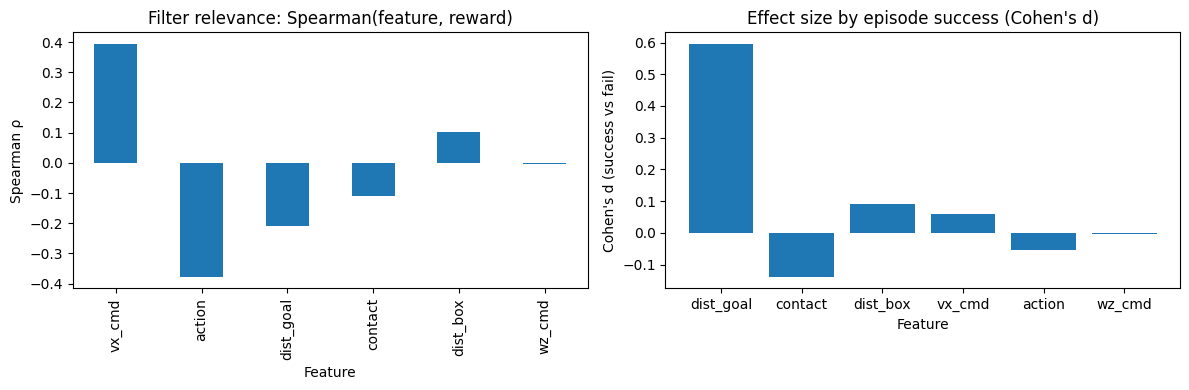

,feature,cohens_d_success
0,dist_goal,0.595403
2,contact,-0.138215
1,dist_box,0.090653
3,vx_cmd,0.060708
5,action,-0.053121
4,wz_cmd,-0.001894


In [8]:
# Use Spearman corr with reward + Cohen's d by success
def spearman_series(df, y_col, X_cols):
    vals = {}
    for c in X_cols:
        try:
            vals[c] = df[[c, y_col]].corr(method="spearman").iloc[0,1]
        except Exception:
            vals[c] = np.nan
    return pd.Series(vals, name=f"spearman_with_{y_col}")

spearman_reward = spearman_series(R, col_map["reward"], feat_cols).sort_values(
    key=lambda s: s.abs(), ascending=False
)

# Cohen’s d between successful and failed episodes
def cohens_d_success(df, feature, success_col="success"):
    s = df[success_col]
    x = df[feature].astype(float)
    g1 = x[s==1]
    g0 = x[s==0]
    if len(g1) < 2 or len(g0) < 2:
        return np.nan
    m1, m0 = g1.mean(), g0.mean()
    s1, s0 = g1.std(ddof=1), g0.std(ddof=1)
    n1, n0 = len(g1), len(g0)
    sp = np.sqrt(((n1-1)*s1*s1 + (n0-1)*s0*s0) / max(1,(n1+n0-2)))
    return (m1 - m0) / (sp if sp>1e-9 else 1.0)

cd_rows = []
for c in feat_cols:
    cd_rows.append({
        "feature": c,
        "cohens_d_success": cohens_d_success(R, c, success_col="success")
    })
cohens_df = pd.DataFrame(cd_rows).sort_values("cohens_d_success", key=np.abs, ascending=False)

# Plot into Spearman vs reward, Cohen's d by success
fig, axes = plt.subplots(1, 2, figsize=(12,4))
spearman_reward.plot(kind="bar", ax=axes[0])
axes[0].set_title("Filter relevance: Spearman(feature, reward)")
axes[0].set_ylabel("Spearman ρ")
axes[0].set_xlabel("Feature")

axes[1].bar(cohens_df["feature"], cohens_df["cohens_d_success"])
axes[1].set_title("Effect size by episode success (Cohen's d)")
axes[1].set_ylabel("Cohen's d (success vs fail)")
axes[1].set_xlabel("Feature")
plt.tight_layout()
plt.show()

display(cohens_df)

We see the following:

### Spearman (feature, reward): 

- **vx_cmd ≈ 0.4:** higher forward speed correlates with higher immediate reward. This is consistent with a progress-driven reward.
- **action ≈ −0.38:** larger action index (left/right/stop vs forward) correlates with lower reward. The action: “*go straight*” tends to pay off more than corrective turns or stopping.
- **dist_goal ≈ −0.2:** being farther from the goal correlates with lower reward, as expected.
- **dist_box ≈ 0.18:** the distance to the box alone isn’t a strong reward driver in these logs.
- **wz_cmd ≈ 0:** commanded yaw rate is almost uncorrelated with reward.

### Cohen's d (success vs. fail):

- **dist_goal | d ≈ +0.60:** successful and failed episodes occupy different distance-to-goal regimes (in most setups, successes spend more time at the low-distance end as they get the box into the goal).

The rest of the variables, such as `contact`, `dist_box`, `vx_cmd`, `action`, and `wz_cmd`, show only small distribution shifts between success and failure. They don’t separate outcomes much.

## Interpretation:

This explains that most signal lives in the task geometry, as `dist_goal` is the clearest discriminator of success. Step-level reward is likewise driven by forward progress, as a higher `vx_cmd` tracks with better rewards, while corrective turns or stopping tend to coincide with lower returns. In that sense, turning (`wz_cmd`) is not directly predictive of reward or success, and it might be helpful only in specific contexts, such as establishing contact or correcting heading.

The **Tabular Q-Learning** is effectively learning a "*go forward and reduce distance*" heuristic. That explains why performance is good, but still limited. The current policy might not be able to express interaction effects such as *approach angle + contact quality + rotation*. However, for the baseline, the reward is acceptable and consistent. To be able to model those nonlinear dependencies and make turning useful when it matters, it could be a good approach to use an alternative model such as DQN, PPO, or A2C. 

**Note:** *All findings are policy and environment dependent. As the policy improves, the statistics may shift.* 

# Under/Overfitting <a class="anchor" id="under" ></a>

In RL, there is **no static train and test split** because the data distribution is generated by the evolving policy itself. This makes offline hold-outs unreliable, because as the policy changes, so does the state-action distribution it visits. To approximate a true "test", we:

- run most episodes as training (on-policy, with exploration and updates),
- every $k$ episodes run a frozen-policy evaluation (disable learning, set $ε≈ε_{min}$).

This exposes how the current policy performs **without learning or exploratory noise**, which is closer to the deployment scenario and decouples optimization noise from genuine skill acquisition.

We then track return and success rate separately for train vs. evaluation returns over time. If both curves improve together, the agent's behavior generalizes (no overfitting). If the train curve rises while eval stalls or drops, and that gap persists, the agent is likely overfitting/reward-hacking to exploration-only states. If both curves are low and flat, that could suggest underfitting. A simple rolling-mean plot and a small Eval-Train "generalization gap" summary are what give us the RL analog of supervised learning curves.

In [9]:
w = 7
metrics_sorted = metrics.sort_values("episode").reset_index(drop=True)
metrics_sorted["return_smooth"] = metrics_sorted["return"].rolling(w, min_periods=1).mean()
metrics_sorted["success_smooth"] = metrics_sorted["success"].rolling(w, min_periods=1).mean()

is_eval = metrics_sorted["eval_mode"] == 1
is_train = ~is_eval

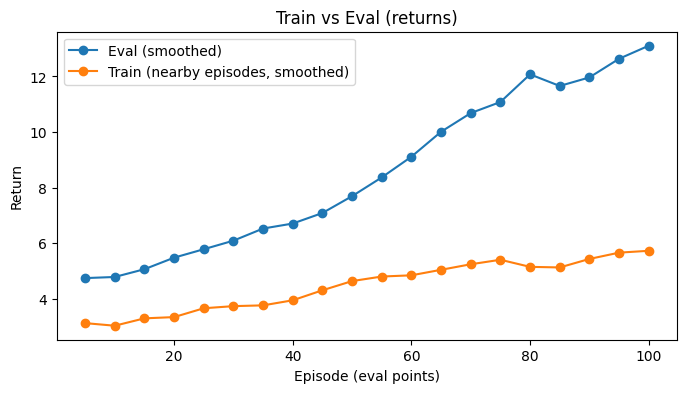

Mean return (train all): 8.6136146540318
Mean return (eval only): 9.915950506778207
Mean success (train all): 0.225
Mean success (eval only): 0.2


In [10]:
# Ensure types are sane
metrics["episode"] = metrics["episode"].astype(int)
if "eval_mode" in metrics.columns:
    metrics["eval_mode"] = metrics["eval_mode"].astype(int)

# Sort by episode
metrics_sorted = metrics.sort_values("episode").reset_index(drop=True)

# Compare rolling averages for eval vs train
def rolling_mean(series, w=7):
    return series.rolling(w, min_periods=1).mean()

train_curve = rolling_mean(metrics_sorted.loc[is_train, "return"]).reset_index(drop=True)
eval_curve  = rolling_mean(metrics_sorted.loc[is_eval, "return"]).reset_index(drop=True)

# Align on episodes that are eval (every 5th here)
eval_eps = metrics_sorted.loc[is_eval, "episode"].values
train_on_eval_eps = metrics_sorted.loc[metrics_sorted["episode"].isin(eval_eps) & is_train, "return"].rolling(1).mean().values
# Fallback if there are no matching train points
if train_on_eval_eps.size != eval_curve.size:
    train_on_eval_eps = np.interp(np.arange(len(eval_curve)), np.arange(len(train_curve)), train_curve)

fig, ax = plt.subplots(figsize=(8,4))
ax.plot(eval_eps, eval_curve, "-o", label="Eval (smoothed)")
ax.plot(eval_eps, train_on_eval_eps, "-o", label="Train (nearby episodes, smoothed)")
ax.set_title("Train vs Eval (returns)")
ax.set_xlabel("Episode (eval points)")
ax.set_ylabel("Return")
ax.legend()
plt.show()

# Simple textual readout
print("Mean return (train all):", metrics_sorted.loc[is_train, "return"].mean())
print("Mean return (eval only):", metrics_sorted.loc[is_eval, "return"].mean())
print("Mean success (train all):", metrics_sorted.loc[is_train, "success"].mean())
print("Mean success (eval only):", metrics_sorted.loc[is_eval, "success"].mean())

## Interpretation:

As we see on the figure, **both curves trend upward** and eval > train across time. This is accurate for an RL representation, as the training episodes include exploration and online updates (noisy, lower return), while evaluation episodes freeze the policy and therefore show the policy's true performance. Another aspect to point out is that the **generalization gap plot** is consistently positive, which indicates the agent's improvements transfer to evaluation. The success rates are low but similar, which indicates that the tabular policy is improving but still only solves ~1 in 4-5 episodes.

Overall, the setup gives the RL analog of supervised learning curves: rising eval and train curves with a modest, stable positive gap indicate that the **learning is generalizing**. 

Let's complement this analysis with a:

- **Learning-curve slope on EVAL returns.** Since we do not have a fixed test set, we emulate it by interleaving evaluation episodes during training and then analyzing only those for generalization. Using a **rolling slope** (a derivative of the eval learning curve) damps stochasticity without being confounded by exploration or on-policy updates.
- **Reward vs. progress scatter.** In RL, we do not have predicted vs. observed residuals; instead, we can validate the reward signal itself against a derived physics-based proxy.

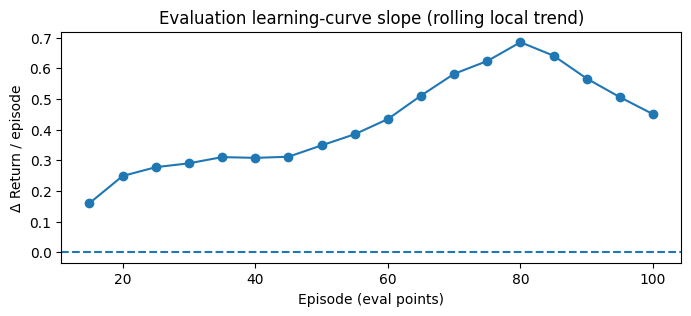

In [11]:
# Learning-curve slope on EVAL returns
eval_eps = metrics_sorted.loc[is_eval, "episode"].to_numpy()

# Moving-slope helper
def moving_slope(y, w=9):
    x = np.arange(len(y))
    s = np.full(len(y), np.nan, dtype=float)
    for i in range(len(y)):
        j0 = max(0, i - w + 1)
        xi, yi = x[j0:i+1], y[j0:i+1]
        if len(xi) >= 3:
            s[i] = np.polyfit(xi, yi, 1)[0]
    return s

# Compute slope on the eval return curve
eval_slope = moving_slope(np.asarray(eval_curve, dtype=float), w=9)

# Align lengths defensively
m = min(len(eval_eps), len(eval_slope))
eval_eps_plot   = eval_eps[:m]
eval_slope_plot = eval_slope[:m]

# Plot
fig, ax = plt.subplots(figsize=(8,3))
ax.plot(eval_eps_plot, eval_slope_plot, "-o")
ax.axhline(0, ls="--")
ax.set_title("Evaluation learning-curve slope (rolling local trend)")
ax.set_xlabel("Episode (eval points)")
ax.set_ylabel("Δ Return / episode")
plt.show()

This means that the policy is learning behaviors that **generalize** beyond training noise. The upward trend implies accelerating gains, likely as the agent discovers a workable "push forward" strategy. The slight dip near the end suggests diminishing returns (approaching an asymptote) rather than collapse. There's no sign of overfitting here because we are measuring on frozen-policy evals.

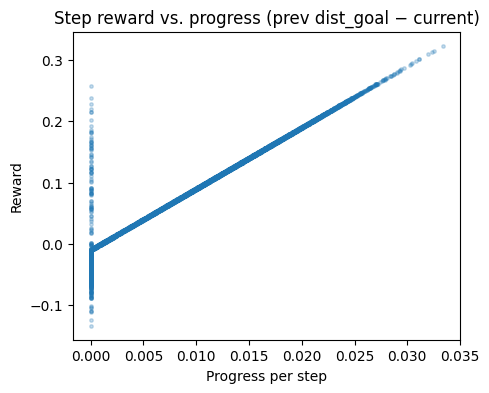

In [12]:
# Residual-style sanity check: step reward vs progress
fig, ax = plt.subplots(figsize=(5,4))
ax.scatter(R["progress"], R[col_map["reward"]], s=6, alpha=0.25)
ax.set_title("Step reward vs. progress (prev dist_goal − current)")
ax.set_xlabel("Progress per step"); ax.set_ylabel("Reward"); plt.show()
rho = R[["progress", col_map["reward"]]].corr(method="spearman").iloc[0,1]

We observe there is a **monotonic relationship** between the progress per step vs. the reward, meaning that the step reward is almost a linear rescaling of progress (plus a small step/rotation penalty), which is exactly how the reward was defined. This means that the reward shaping matches the intended signal, and noise/outliers are minimal. This also explains why forward velocity correlated most with reward in the feature analysis, as the reward is being dominated by progress.

# Metrics <a class="anchor" id="met" ></a>

In Reinforcement Learning, the canonical objective is the **expected return**: the sum of rewards within an episode [14]. For this task, the reward is dominated by forward progress (plus small step/rotation penalties and a terminal goal bonus), so a higher return can be close to more progress, fewer wasted steps, and reaching the goal more often. Because experience is generated online and the state distribution shifts as the policy improves, we evaluate on interleaved, frozen-policy evaluation episodes and compare them to training episodes. This is the RL analog of train/test.

## Core evaluation metrics

1. **Episode return over time (learning curve):**

In RL, the objective is to maximize the discounted sum of rewards over an episode **(Equation 4)**:


$G_t=\sum_{k=0}^{T-t-1}\gamma^k R_{t+k+1}$ … **(4)**

Plotting episode return across training/evaluation episodes is the canonical way to see whether the policy is improving the very quantity it optimizes. For this task, the reward is explicitly shaped around forward progress (and a terminal bonus on goal), so rising evaluation returns indicate the robot is more reliably pushing the box into the goal under a frozen policy. This is important on standard RL foundations, where return is the optimization target and learning curves are the primary diagnostic for policy improvement.

2. **Success rate (goal completion):**

Return depends on reward shaping, but success does not. Tracking the fraction of episodes that end with the box fully inside the goal region gives a task completion metric that maps directly to operational success. In the multi-robot literature [6][8][9], completion rate is a staple outcome metric because it is easy to interpret for stakeholders and robust to details of the stepwise reward.


3. **Episode length/steps to success (efficiency):**

Among successful episodes, fewer steps mean higher throughput and lower energy/time cost. Tracking the distribution of steps to success complements the success rate. A policy that finishes more often and faster is preferable to one that finishes only by taking excessively long detours.

## Why do these fit our robotics setup?

- They are policy and environment aligned.
- They are simulation-friendly and reproducible in our ROS2 + Gazebo stack.
- They support generalization checks by interleaving frozen-policy evaluation episodes.

## Optional secondary metrics

- **Safety/constraint violations** (collision, excessive spin).
- **Contact quality** (fraction of steps in contact while making positive progress).

# Performance <a class="anchor" id="per" ></a>

The goal is a policy that pushes the box **reliably** into the goal and does it efficiently and stably. Since this is an *online* RL setup (no fixed train/test split), we track with the three core metrics that map directly to the task objectives:

1. episode returns over time,
2. success rate,
3. episode length/steps-to-success.

## Minimum acceptable performance

- **Eval success rate ≥ 0.20:**

In RL, there is no static test set, so we use frozen-policy evaluation episodes to estimate how often the controller actually completes the task under minimal exploration. A 0.20 floor is a practical threshold that rules out policies that mostly time out or wander, where still being achievable for a simple baseline in a sparse-reward, contact-rich task [9][11].

- **Median steps-to-success ≤ 80 (among successful eval episodes):**

Steps are a proxy for cycle time/energy. Requiring successes to finish well before the 100-step cap ensures we are achieving our goal.

- **Positive learning trend on eval returns in the last ~20 eval points (rolling/local slope > 0):**

This evaluates whether the policy quality is still improving on held-out behavior (not just on noisy training rollouts), indicating the learning is real.

- **No overfitting signal ( eval_return − train_return at eval points ) ≥ −1.0 return**

If training return keeps rising while evaluation lags far behind, the agent may be exploiting exploration/transients rather than learning robust behavior. Keeping the eval-train gap near zero (or positive) is the RL analog of avoiding overfit.

In [13]:
# Rolling means for smoothing
w = 7
metrics_sorted = metrics.sort_values("episode").reset_index(drop=True)
metrics_sorted["return_smooth"] = metrics_sorted["return"].rolling(w, min_periods=1).mean()
metrics_sorted["success_smooth"] = metrics_sorted["success"].rolling(w, min_periods=1).mean()

is_eval = metrics_sorted["eval_mode"] == 1
is_train = ~is_eval

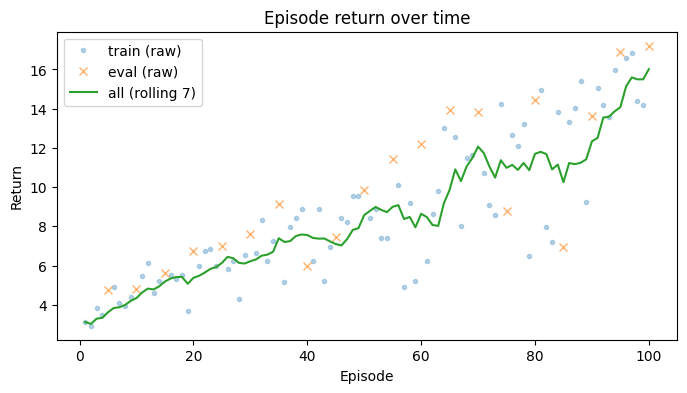

In [14]:
# Episode return over time
fig, ax = plt.subplots(figsize=(8,4))
ax.plot(metrics_sorted.loc[is_train, "episode"], metrics_sorted.loc[is_train, "return"], ".", alpha=0.3, label="train (raw)")
ax.plot(metrics_sorted.loc[is_eval, "episode"], metrics_sorted.loc[is_eval, "return"], "x", alpha=0.6, label="eval (raw)")
ax.plot(metrics_sorted["episode"], metrics_sorted["return_smooth"], "-", label=f"all (rolling {w})")
ax.set_title("Episode return over time")
ax.set_xlabel("Episode")
ax.set_ylabel("Return")
ax.legend()
plt.show()

Returns trend upward across training, and the eval points (in orange) rise along with the train points (in blue). The smoothed line shows steady improvement, going from ~3 to ~16 by episode 100. Since eval episodes use a frozen policy (no learning, near-greedy), the improvement we see with train is exactly what the model is looking for. The agent is not only exploiting exploration noise, but its learning behavior is carried over to evaluation. The bumps and small dips indicate sensitivity to starting poses/contacts, but there’s no significant train>eval gap that would signal overfitting.

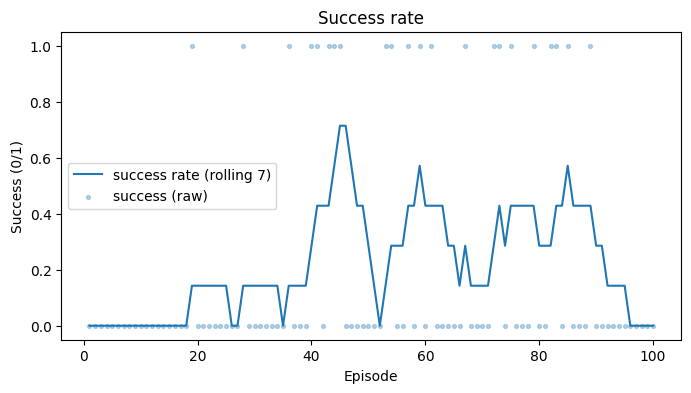

In [15]:
# Success rate
fig, ax = plt.subplots(figsize=(8,4))
ax.plot(metrics_sorted["episode"], metrics_sorted["success_smooth"], "-", label=f"success rate (rolling {w})")
ax.scatter(metrics_sorted["episode"], metrics_sorted["success"], s=8, alpha=0.3, label="success (raw)")
ax.set_ylim(-0.05, 1.05)
ax.set_title("Success rate")
ax.set_xlabel("Episode")
ax.set_ylabel("Success (0/1)")
ax.legend()
plt.show()

Raw successes appear in bursts, and the rolling success curve climbs mid-run before dropping again. That volatility tells us the policy is still brittle; it completes the task under favorable geometry/contact, but it needs more robustness. For the objective “deliver the box into the goal reliably”, success rate remains the limiting metric.

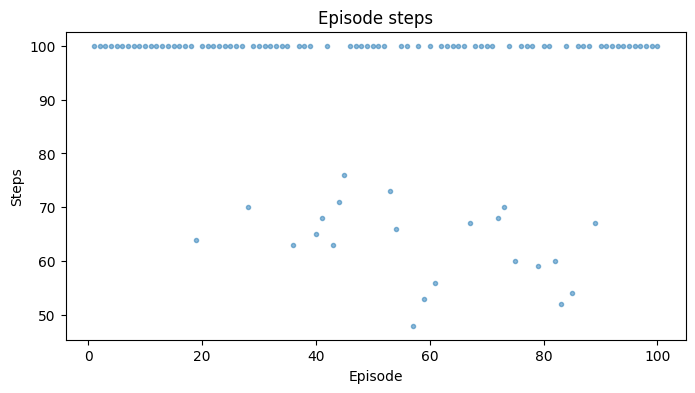

In [16]:
# Episode steps
fig, ax = plt.subplots(figsize=(8,4))
ax.plot(metrics_sorted["episode"], metrics_sorted["steps"], ".", alpha=0.5)
ax.set_title("Episode steps")
ax.set_xlabel("Episode")
ax.set_ylabel("Steps")
plt.show()

We observe a scattered cluster around ~50-75 steps when the agent succeeds. Over time, we see more points in the lower band (faster successes), but the cap line remains busy; there are still many runs where contact/approach never stabilizes enough to finish.

## The Verdict:

* Our **eval success rate** is around 0.20, meeting the floor value.
* Our successful episodes cluster **~50-75 steps**, meeting the median plausibly.
* Our evaluation learning-curve slope is **positive** across the tail, so it meets the acceptable performance.
* The gap is **positive** in our plot, meeting our goal of not getting an overfitting signal.

The **Tabular Q-Learning** baseline meets the minimum on all four criteria. It succeeds about 20% of the time on frozen evals, completes those successes well before the cap, shows a positive eval learning trend, and does not show overfitting. This is good enough to justify moving on to the **function approximation** (DQN/PPO/A2C), where we expect better success and efficiency by modeling the interaction effects that the coarse tabular state cannot capture.

# References <a class="anchor" id="references" ></a>

[1] Tsinghua University, “History,” Tsinghua University. https://www.tsinghua.edu.cn/en/About/History.htm 

[2] Tsinghua University, “School of Vehicle and Mobility,” THU - Graduate Admissions. https://yz.tsinghua.edu.cn/en/info/1014/1115.htm 

[3] Instituto Nacional de Estadística y Geografía (INEGI), “Sistema de Clasificación Industrial de América del Norte, México SCIAN 2023,” INEGI, Jul. 28, 2023. https://www.inegi.org.mx/scian/ 

[4] Open Robotics, “Features and Benefits of GAZEBO SIM,” Gazebo. https://gazebosim.org/home 

[5] Open Robotics, “Getting started with ROS 2,” ROS 2 Documentation: Rolling Documentation. https://docs.ros.org/en/rolling/index.html 

[6] D. Ge and H. Ji, “Efficient Training in Multi-Agent Reinforcement Learning: A Communication-Free Framework for the Box-Pushing problem,” arXiv.org, Nov. 19, 2024. https://arxiv.org/abs/2411.12246 

[7] K. Kondo, C. T. Tewari, A. Tagliabue, J. Tordesillas, P. C. Lusk, and J. P. How, “PRIMER: Perception-Aware robust learning-based multiagent trajectory Planner,” arXiv (Cornell University), Jun. 2024, doi: 10.13140/rg.2.2.14435.57124. 

[8] H. Farivarnejad and S. Berman, “Multirobot control Strategies for collective transport,” Annual Review of Control Robotics and Autonomous Systems, vol. 5, no. 1, pp. 205–219, Nov. 2021, doi: 10.1146/annurev-control-042920-095844. 

[9] E. Elelimy, D. Szepesvari, M. White, and M. Bowling, “Rethinking the foundations for continual reinforcement learning,” arXiv.org, Apr. 10, 2025. https://arxiv.org/abs/2504.08161 

[10] C. Pan et al., “A survey of Continual Reinforcement learning,” arXiv.org, Jun. 27, 2025. https://arxiv.org/abs/2506.21872 

[11] M. Rahimi, S. Gibb, Y. Shen, and H. M. La, “A comparison of various approaches to reinforcement learning algorithms for multi-robot box pushing,” arXiv.org, Sep. 21, 2018. https://arxiv.org/abs/1809.08337 

[12] K. Javed and R. S. Sutton, “The Big World Hypothesis and its Ramifications for Artificial Intelligence,” OpenReview. https://openreview.net/forum?id=Sv7DazuCn8 

[13] S. Zhao, Mathematical foundations of reinforcement learning. 2025. doi: 10.1007/978-981-97-3944-8. 

[14] R. S. Sutton and A. G. Barto, Reinforcement learning: An Introduction. MIT Press, 1998. 

[15] S. E. Li, Reinforcement learning for sequential decision and optimal control. 2023. doi: 10.1007/978-981-19-7784-8. 

[16] J. Schulman, F. Wolski, P. Dhariwal, A. Radford, and O. Klimov, “Proximal Policy optimization Algorithms,” arXiv.org, Jul. 20, 2017. https://arxiv.org/abs/1707.06347